# Preprocessing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

newspaper_df = pd.read_excel('data/NewspaperChurn_new_version.xlsx')
display(newspaper_df.head())
display(newspaper_df.info())

,SubscriptionID,HH Income,Home Ownership,Ethnicity,dummy for Children,Year Of Residence,Age range,Language,Address,State,City,County,Zip Code,weekly fee,Deliveryperiod,Nielsen Prizm,reward program,Source Channel,Subscriber
0,180590686,"$ 30,000 - $39,999",RENTER,German,N,1,25-29,German,1 3RD PL UNIT 703,CA,LONG BEACH,LOS ANGELES,90802,$7.00 - $7.99,7Day,FM,0,CircAdm,NO
1,181401653,"$500,000 Plus",OWNER,unknown,Y,14,50-54,NaN,1 AVIGNON,CA,NEWPORT COAST,ORANGE,92657,$0.01 - $0.50,SunOnly,MW,0,Partner,YES
2,180374685,"$100,000 - $124,999",OWNER,Italian,Y,7,45-49,English,1 BLACKSWAN,CA,IRVINE,ORANGE,92604,$0.01 - $0.50,SunOnly,MW,0,Partner,YES
3,180703483,"$200,000 - $249,999",OWNER,English,N,23,55-59,English,1 BLUE HORIZON,CA,LAGUNA NIGUEL,ORANGE,92677,$1.00 - $1.99,SunOnly,MW,1,Internet,NO
4,180358906,"$ 50,000 - $59,999",OWNER,Italian,N,23,60-64,English,1 BRISA DEL LAGO,CA,RANCHO SANTA MARGARITA,ORANGE,92688,$8.00 - $8.99,Thu-Sun,MM,0,Crew,YES


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15855 entries, 0 to 15854
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   SubscriptionID      15855 non-null  int64 
 1   HH Income           15855 non-null  object
 2   Home Ownership      15855 non-null  object
 3   Ethnicity           15855 non-null  object
 4   dummy for Children  15855 non-null  object
 5   Year Of Residence   15855 non-null  int64 
 6   Age range           15747 non-null  object
 7   Language            14848 non-null  object
 8   Address             15855 non-null  object
 9   State               15855 non-null  object
 10  City                15855 non-null  object
 11  County              15855 non-null  object
 12  Zip Code            15855 non-null  int64 
 13  weekly fee          15669 non-null  object
 14  Deliveryperiod      15855 non-null  object
 15  Nielsen Prizm       15726 non-null  object
 16  reward program      15

None

In [3]:
# 수치형, 범주형 데이터 컬럼 조회
numerical = newspaper_df.select_dtypes(include=["int64"]).columns.tolist()
categorical = newspaper_df.select_dtypes(include=["object"]).columns.tolist()
print(numerical)
print(categorical)

['SubscriptionID', 'Year Of Residence', 'Zip Code', 'reward program']
['HH Income', 'Home Ownership', 'Ethnicity', 'dummy for Children', 'Age range', 'Language', 'Address', 'State', 'City', 'County', 'weekly fee', 'Deliveryperiod', 'Nielsen Prizm', 'Source Channel', 'Subscriber']


## 0-0. Target 값 (Subscriber) binary 변환 (is_churned이라는 새로운 target 컬럼 생성) 
- 'YES', 'NO' => **is_churned**이 1 (이탈) 혹은 0 (이탈 X)

In [4]:
# 예시: Subscirber==0  =  is_churned==1 
newspaper_df['is_churned'] = newspaper_df['Subscriber'].apply(lambda x: 1 if x == 'NO' else 0)

## 0-1. dummt for Children 컬럼 binary 변환

In [5]:
# Map Y → 1, N → 0
newspaper_df['dummy for Children'] = newspaper_df['dummy for Children'].map({'Y': 1, 'N': 0})

## 1. 결측치 처리

In [6]:
newspaper_df.isna().sum()

SubscriptionID           0
HH Income                0
Home Ownership           0
Ethnicity                0
dummy for Children       0
Year Of Residence        0
Age range              108
Language              1007
Address                  0
State                    0
City                     0
County                   0
Zip Code                 0
weekly fee             186
Deliveryperiod           0
Nielsen Prizm          129
reward program           0
Source Channel           0
Subscriber               0
is_churned               0
dtype: int64

### 1.1. 나이구간 결측치 처리

In [7]:
# 'Age range'가 null인 row 제거
newspaper_df = newspaper_df.dropna(subset=['Age range'])

### 1.2 Language 결측치 처리
- 결측이 약 6.3%가 되기 때문에 무작정 삭제 하는 것이 옳바르지는 않음
- **언어가 Unknown인 부류와 아닌 부류의 이탈률에 의미 있는 차이가 없음**
- Language는 보조적 분류 변수로서 사용될 가능성이 있음
- language 보다 더 중요한 특성들의 행까지 삭제되는 것을 방지할 필요가 있음
  
**따라서 현재 분석에선 "Unknown"으로 처리하는 방식이 더 안전하고 실용적**

In [8]:
newspaper_df['Language'].isna().sum()

np.int64(1000)

In [9]:
newspaper_df['Language'].isna().sum()
## 결측값을 Unknown으로 부여했을 때 이탈율 비교

# Language 컬럼의 결측값을 'Unknown'으로 대체
newspaper_df['Language'] = newspaper_df['Language'].fillna('Unknown')


# 언어가 Unknown인 경우와 아닌 경우로 나누어 이탈률 비교
churn_unknown = newspaper_df[newspaper_df['Language'] == 'Unknown']['is_churned'].mean()
churn_known = newspaper_df[newspaper_df['Language'] != 'Unknown']['is_churned'].mean()

print(f"이탈률 (Language = Unknown): {churn_unknown:.4f}")
print(f"이탈률 (Language ≠ Unknown): {churn_known:.4f}")

이탈률 (Language = Unknown): 0.8050
이탈률 (Language ≠ Unknown): 0.8083


### 1.3. Weekley Fee 결측치 처리
- 결측률: 약 1.8%
- 이탈 v.s. 잔류 비율이 19.2% 와 80.8%이기 때문에, 1.8%의 손실은 모델 성능에 큰 변화를 주지 않는다고 생각 => 결측치 제거
 

In [10]:
newspaper_df['weekly fee'].unique()

array(['$7.00 - $7.99', '$0.01 - $0.50', '$1.00 - $1.99', '$8.00 - $8.99',
       '$0 - $0.01', '$2.00 - $2.99', '$9.00 - $9.99', '$4.00 - $4.99',
       '$0.51 - $0.99', '$3.00 - $3.99', '$5.00 - $5.99', '$6.00 - $6.99',
       '$10.00 - $10.99', nan, '$0'], dtype=object)

In [11]:
# 결측 vs 비결측 이탈률 확인
isnull_group = newspaper_df[newspaper_df['weekly fee'].isnull()]
notnull_group = newspaper_df[newspaper_df['weekly fee'].notnull()]

churn_null = isnull_group['is_churned'].mean()
churn_notnull = notnull_group['is_churned'].mean()

print(f"이탈률 (요금 결측): {churn_null:.4f}")
print(f"이탈률 (요금 있음): {churn_notnull:.4f}")

이탈률 (요금 결측): 1.0000
이탈률 (요금 있음): 0.8058


- 대안 1: '결측여부'를 나타내는 'weekly_fee_missing'를 생성 (X)
- 대안 2: 결국 결측치를 그대로 둘 수 없기 때문에, 모든 결측치가 이탈이므로 결측치에 해당하는 weekly fee 깂을 'Not Paying' 범주 추가 할당 (X)

In [12]:
# 0. 그냥 null 컬럼 제거
newspaper_df = newspaper_df.dropna(subset=['weekly fee'])

# 1. null들에 'Not Paying'이라는 값 부여
#newspaper_df['weekly fee'] = newspaper_df['weekly fee'].fillna('Not Paying')

# 2. weekly fee 결측 여부를 나타내는 새로운 컬럼 생성 (1 = 결측, 0 = 비결측)
# newspaper_df['weekly_fee_missing'] = newspaper_df['weekly fee'].isnull().astype(int)

### 1.4. Nielsen Prizm 전처리 (우선 drop 채택, 추가적인 고려 필요)
**Nielsen Prizm**: 소비자의 인구통계학적 특성과 라이프스타일에 따라 고객을 여러 세그먼트로 분류하는 코드 기반 마케팅 세분화 시스템 (연령, 성별, 가족 구성 또는 경제 활동 상태 등을 요약적으로 표현)이라고 추정 => **이 특성이 나이와 소득을 반영한다면 어떻게 처리할 지 고민을 해봐야 함**

- 결측치가 0.8% 정도 밖에 차지 안하므로, null 값 row는 제거 

In [13]:
# 유니크 값 확인
newspaper_df['Nielsen Prizm'].unique()

array(['FM', 'MW', 'MM', 'FW', 'YW', 'YM', nan, 'ME', 'YE', 'FE'],
      dtype=object)

In [14]:
newspaper_df = newspaper_df.dropna(subset=['Nielsen Prizm'])

## 2. Unknown 범주 데이터 처리
- 범주형 데이터 중 unknown 범주를 가지는 컬럼 조회

In [15]:
# 범주형 데이터 중 unknown 범주를 가지는 컬럼 조회

for col in categorical:
    if newspaper_df[col].astype(str).str.lower().isin(['unknown']).any():
        unique_vals = newspaper_df[col].unique()
        print(f"{col}: {unique_vals}")

Ethnicity: ['German' 'unknown' 'Italian' 'English' 'Scottish (Scotch)' 'Hispanic'
 'Chinese' 'Irish' 'Swedish' 'Filipino (Philippine)' 'Jewish' 'Arab'
 'Japanese' 'Indian' 'Vietnamese' 'Persian' 'French' 'Korean' 'Turkish'
 'Norwegian' 'Armenian' 'Polish' 'Portuguese' 'Dutch' 'Welsh' 'Belgian'
 'Byelorussian (Belarusian)' 'Czech' 'Thai' 'Ukrainian' 'African (other)'
 'Danish' 'Native American (American Indian)' 'Zimbabwean' 'Hungarian'
 'Russian' 'Austrian' 'Pakistani' 'Greek' 'Khmer (Kampuchean, Cambodian)'
 'Lithuanian' 'Romanian' 'African American 95%+' 'Egyptian' 'Ethiopian'
 'multi-ethnic' 'Slovakian (Slovak)' 'Serbian' 'Swiss' 'Laotian' 'Ugandan'
 'Finnish' 'Croatian' 'Ruandan (Rwandan)' 'Malawian' 'Indonesian'
 'Angolan' 'Latvian' 'Iraqi' 'Hawaiian' 'Syrian' 'Albanian' 'Ghanaian'
 'Slovenian (Slovene)' 'Kenyan' 'Myanmar (Burma)' 'Bulgarian' 'Bhutanese'
 'Swaziland' 'Nigerian' 'Luxembourgian' 'Estonian'
 'Zairian (Democratic Republic of the Con']
Language: ['German' 'Unknown' 'En

- Language는 결측치 처리에서 unknown을 만든 것이므로 제외
- Ethnicity의 unknown 범주에 속하는 데이터 개수는 Language와 똑같이 6.3%. 

In [16]:
newspaper_df[newspaper_df['Ethnicity'].astype(str).str.lower() == 'unknown'].shape[0] / newspaper_df.shape[0] * 100

6.32853996631688

- Language의 경우와 똑같은 비율이므로 두 변수의 unknown이 공통인지 확인해본 결과 서로 일치
- Ethnicity 컬럼도 unknown 범주 유지 결정

In [17]:
mask_ethnicity = newspaper_df['Ethnicity'].astype(str).str.lower() == 'unknown'
mask_language = newspaper_df['Language'].astype(str).str.lower() == 'unknown'

both_unknown = (mask_ethnicity & mask_language).sum()

ethnicity_unknown = mask_ethnicity.sum()
language_unknown = mask_language.sum()

print(f"Ethnicity == 'unknown'인 행 수: {ethnicity_unknown}")
print(f"Language == 'unknown'인 행 수: {language_unknown}")
print(f"둘 다 'unknown'인 행 수: {both_unknown}")

Ethnicity == 'unknown'인 행 수: 977
Language == 'unknown'인 행 수: 977
둘 다 'unknown'인 행 수: 977


## 3. 이상치 처리
- 수치형 변수들 간의 이상치 조회
- 논의 필요

In [18]:
print(numerical)

['SubscriptionID', 'Year Of Residence', 'Zip Code', 'reward program']


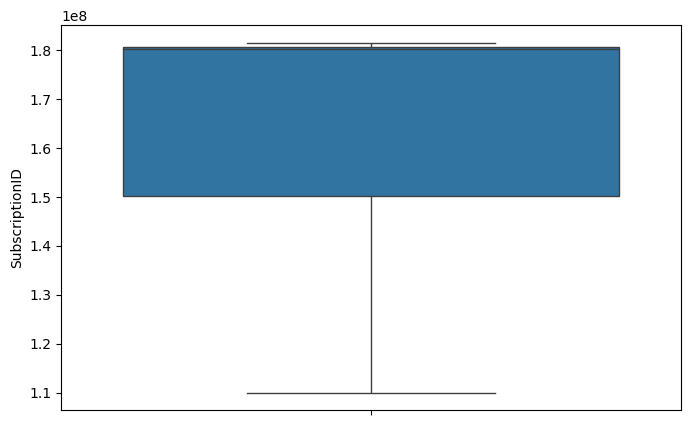

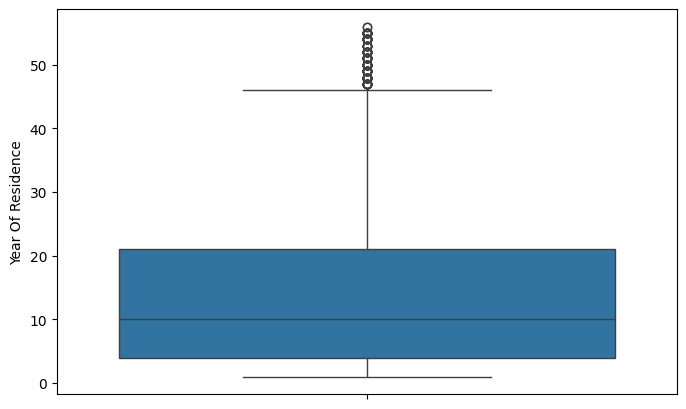

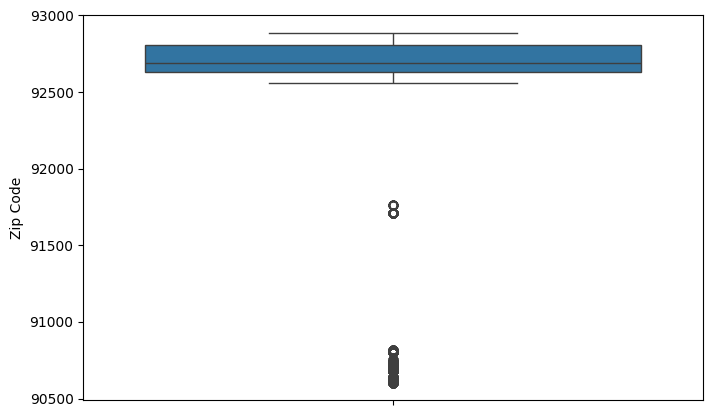

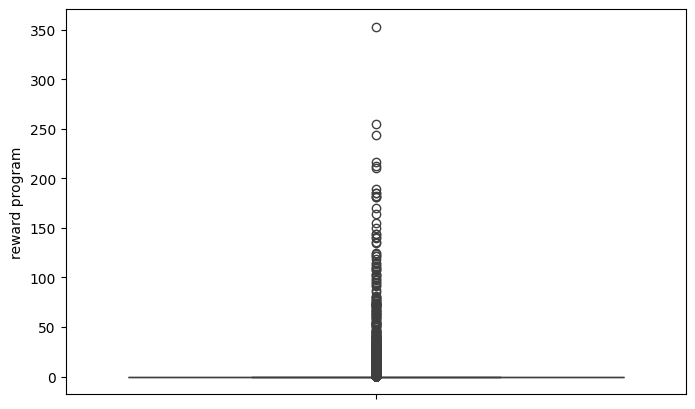

In [19]:
# boxplot을 사용하여 각 변수의 이상치 시각화
for var in numerical:
    plt.figure(figsize=(8, 5))
    sns.boxplot(y=newspaper_df[var])
    plt.show()

## 4. 범주형 데이터 변환

#### 4.1. 나이 수치형 데이터로 변환
- 성인 기준: **18살 이상**
    - https://www.law.cornell.edu/wex/age_of_majority#:~:text=The%20age%20of%20majority%20refers%20to%20the,or%20the%20right%20to%20sign%20a%20contract.
- 미국 2024년 평균 기대수명: **78.4살**
    - https://www.cdc.gov/nchs/fastats/life-expectancy.htm#:~:text=Both%20sexes:%2078.4%20years.%20Males:%2075.8%20years.%20Females:%2081.1%20years.

**<연령대('Age range'\) 데이터를 정규분포 기반의 수치형 나이로 변환하는 접근의 타당성>**  
- 연령대 범위 내 정규분포 기반의 무작위 나이 생성 방식은 전처리 단계에서 통계적 타당성과 실용성을 모두 갖춘 방법. 각 연령대 범위를 하위 계층으로 간주하고, 해당 범위 내에서 중심값을 기준으로 정규분포를 따라 값을 생성함으로써, 범위 내 연령 분포의 자연스러움을 보존 가능. 
- 이는 층화 샘플링(stratified sampling)과 유사한 원리를 따르며, 층화는 모집단의 하위 그룹 간 분산을 감소시키고 대표성을 보장함으로써 예측 성능 향상에 기여하는 것으로 알려짐 (Lohr, 2021; Cochran, 1977). 
- 또한 머신러닝 모델의 입력값으로 사용되는 순서형 범주형 변수는 단순 레이블 인코딩보다 수치화될 때 모델이 정보의 상대적 크기를 더 잘 이해하게 되며, 특히 로지스틱 회귀나 트리 기반 모델에서 효과적이다 (Zhang et al., 2021). 따라서 해당 방식은 정보 손실 없이 연령대를 정량화하고, 이탈 예측에 중요한 피처로 반영하기 위한 전처리 전략으로서 충분히 정당화될 수 있음.

In [20]:
age_group_bounds = {
    '24 years or less': (18, 24), # 24세 이하 (최소값은 임의로 18로 설정)
    '25-29': (25, 29),
    '30-34': (30, 34),
    '35-39': (35, 39),
    '40-44': (40, 44),
    '45-49': (45, 49),
    '50-54': (50, 54),
    '55-59': (55, 59),
    '60-64': (60, 64),
    '65-69': (65, 69),
    '70-74': (70, 74), 
    '75 years or more': (75, 80) # 나이 최대 값은 80세
}

# 나이 부여 함수
def sample_age(age_range, n_samples):
    low, high = age_group_bounds[age_range]
    mean = (low + high) / 2  # 평균은 범위의 중앙값
    std = (high - low) / 4   # 표준편차는 범위의 1/4 정도로 설정 (약 95%가 범위 안에 들도록)
    sampled = np.random.normal(loc=mean, scale=std, size=n_samples) # 정규분포 샘플링
    return np.clip(np.round(sampled), low, high).astype(int) # 정수로 반올림하고 범위 내로 제한


# Age 컬럼 생성
newspaper_df['Age'] = newspaper_df['Age range'].apply(
    lambda group: sample_age(group, 1)[0] if pd.notnull(group) else np.nan
)

### 4.2. 소득 구간 정보 범주형 -> 수치형 변환

**<로그 정규분포 기반 소득 샘플링 적용의 타당성>**  
- 미국의 개인 소득 및 가구 소득 분포는 일반적인 정규분포가 아닌, 오른쪽으로 긴 꼬리를 가지는 비대칭 분포, 즉 **로그 정규분포나 파레토 분포(Pareto distribution)**의 형태를 띤다고 널리 알려져 있음. 이러한 특성은 고소득자가 전체 소득에서 차지하는 비중이 높고, 대다수는 중·저소득에 밀집해 있는 현실을 반영. 미국 인구조사국(Census Bureau)의 2023년 자료에 따르면, 가구 중위 소득은 약 $80,610이지만, 상위 10%의 소득 하한은 $234,769에 달하며, 상위 1%의 경우 $631,500 이상을 기록했습니다(DQYDJ, 2024). 이처럼 평균보다 중위값이 훨씬 낮고, 소수의 고소득자가 평균치를 끌어올리는 경향은 정규분포보다는 로그 정규분포가 실제 소득 분포를 더 잘 설명한다는 증거.

- 또한 학술 연구들 역시 이러한 접근을 지지. 많은 통계학 및 경제학 연구에서 소득이나 자산의 분포를 모델링할 때 로그 정규분포를 사용하는 것이 일반적, 이는 모델이 현실을 보다 정확히 반영할 수 있도록 도움 (Clauset et al., 2009; Reed & Jorgensen, 2004). 특히 머신러닝 프로젝트의 입력 변수로 사용되는 소득 정보는 정규성 가정(normality assumption)을 만족할 필요는 없지만, 현실적인 값과 분포를 유지해야 과적합이나 왜곡 없이 일반화 가능한 모델을 만드는 데 기여.

- 따라서 'Income range' 범주를 바탕으로 각 구간의 하한과 상한을 정한 후, 로그 정규분포를 기반으로 현실적인 소득 값을 샘플링하는 방법이 가장 적절하며, 통계적으로도, 실용적으로도, 그리고 실제 소득 분포의 특성과도 부합하는 합리적인 선택.

In [21]:
# 1. 소득 구간별 하한/상한 정의
income_bounds = {
    'Under $20,000': (10000, 19999),
    '$  20,000 - $29,999': (20000, 29999),
    '$  30,000 - $39,999': (30000, 39999),
    '$  40,000 - $49,999': (40000, 49999),
    '$  50,000 - $59,999': (50000, 59999),
    '$  60,000 - $69,999': (60000, 69999),
    '$  70,000 - $79,999': (70000, 79999),
    '$  80,000 - $89,999': (80000, 89999),
    '$  90,000 - $99,999': (90000, 99999),
    '$100,000 - $124,999': (100000, 124999),
    '$125,000 - $149,999': (125000, 149999),
    '$150,000 - $174,999': (150000, 174999),
    '$175,000 - $199,999': (175000, 199999),
    '$200,000 - $249,999': (200000, 249999),
    '$250,000 - $299,999': (250000, 299999),
    '$300,000 - $399,999': (300000, 399999),
    '$400,000 - $499,999': (400000, 499999),
    '$500,000 Plus': (500000, 750000),  # 상위 1% 소득 하한($631,500)을 감안해서 유연함 반영 (출처: DQYDJ, 2024)
}

# 2. 로그 정규분포 기반 샘플링 함수 정의
def sample_log_normal_income(income_range, n_samples=1):
    if income_range not in income_bounds or pd.isnull(income_range):
        return np.nan

    low, high = income_bounds[income_range]
    mu = np.log((low + high) / 2)
    sigma = 0.4  # 분포의 퍼짐 정도 (값이 작을수록 중앙에 집중, 클수록 상한/하한 근처까지 다양하게 퍼짐 => 0.4, 0.5가 중간값 중심 분포를 유지하면서도 현실적인 다양성을 부여하는 수준)

    sample = np.random.lognormal(mean=mu, sigma=sigma, size=n_samples)
    clipped = np.clip(sample, low, high)
    return int(round(clipped[0]))

# 3. 적용: 새로운 'Income' 컬럼 생성
newspaper_df['Income'] = newspaper_df['HH Income'].apply(sample_log_normal_income)

### 4.3 나이, 소득 전처리 결과 타당성 확인
-  두 변수의 통계 및 히스토그램 확인

In [22]:
newspaper_df[['Age', 'Income']].describe()

,Age,Income
count,15438.000000,15438.000000
mean,52.503498,111854.449734
std,15.588179,111311.268210
min,18.000000,10000.000000
25%,41.000000,39999.000000
50%,52.000000,80000.000000
75%,64.000000,145307.750000
max,80.000000,750000.000000


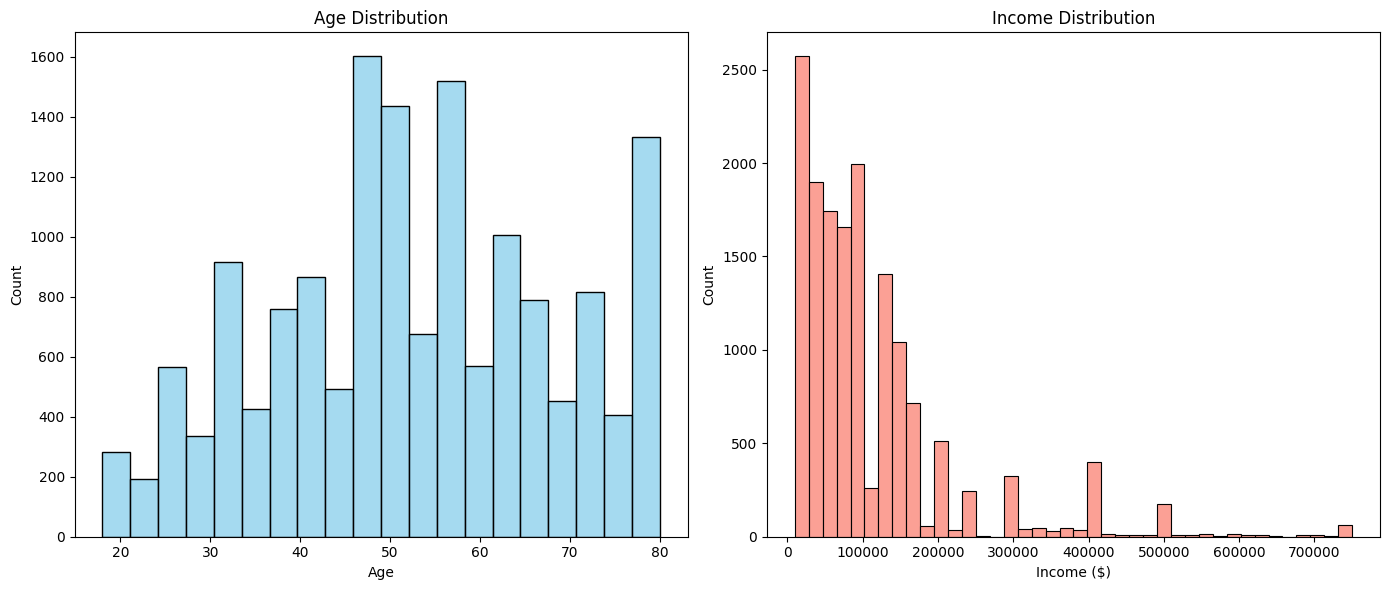

In [23]:
plt.figure(figsize=(14, 6))

#나이 히스토그램
plt.subplot(1, 2, 1)
sns.histplot(newspaper_df['Age'], bins=20, kde=False, color='skyblue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")

# 소득 히스토그램
plt.subplot(1, 2, 2)
sns.histplot(newspaper_df['Income'], bins=40, kde=False, color='salmon')
plt.title("Income Distribution")
plt.xlabel("Income ($)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


- 전처리된 Age 변수는 평균 52.5세, 중간값 52세, 표준편차 15.6의 값을 가지며, 최솟값 18세, 최댓값 80세 범위로 분포하였다. 히스토그램을 통해 살펴보면 30대 후반부터 60대 초반에 이르기까지 높은 밀도를 보이며, 젊은 층과 고령층도 균형 있게 포함되어 있음을 확인할 수 있다. 이는 각 연령대 범위 내에서 정규분포를 기반으로 샘플링한 방식이 실제 성인 구독자층의 인구 구조와 유사하게 반영되었음을 의미함.

- Income 변수는 평균 $112,000, 중간값 $80,000, 표준편차 $111,525의 값을 나타내며, 최대 $750,000까지의 값이 존재한다. 소득 히스토그램은 전형적인 로그 정규분포 형태를 보이며, 대다수의 구독자가 $100,000 이하의 구간에 분포하고, 고소득 구간으로 갈수록 빈도가 급격히 줄어드는 우측 꼬리 구조를 보인다. 이는 실제 미국 소득 분포의 특성과 잘 부합하며, 범주형 소득 데이터를 로그 정규분포 기반으로 수치화한 접근이 현실적인 소득 구조를 왜곡 없이 반영했음을 시각적으로 입증.

## 5. 불필요한 컬럼 삭제
- 파생변수로 인해 불필요해진 기존 컬럼 ('HH Income', 'Age range', 'Subscriber')
- 뚜렷한 관련이 없는 컬럼('SubscriptionID', 'State', 'Zip Code', 'Address')

In [24]:
newspaper_df.columns.to_list()

['SubscriptionID',
 'HH Income',
 'Home Ownership',
 'Ethnicity',
 'dummy for Children',
 'Year Of Residence',
 'Age range',
 'Language',
 'Address',
 'State',
 'City',
 'County',
 'Zip Code',
 'weekly fee',
 'Deliveryperiod',
 'Nielsen Prizm',
 'reward program',
 'Source Channel',
 'Subscriber',
 'is_churned',
 'Age',
 'Income']

In [25]:
newspaper_df.drop(['SubscriptionID', 'HH Income', 'Age range', 'State', 'Zip Code', 'Address', 'Subscriber'], axis=1, inplace=True)

## (맹지수님 발견) Delivery Period 중복값 통일
예시: 7Day == 7day

In [26]:
# Mapping only for exact duplicates you listed
dup_map = {
    'THU-SUN': 'Thu-Sun',
    'thu-sun': 'Thu-Sun',
    'SUNONLY': 'SunOnly',
    'sunonly': 'SunOnly',
    '7DAY': '7Day',
    '7day': '7Day'
}

newspaper_df['Deliveryperiod'] = newspaper_df['Deliveryperiod'].replace(dup_map)

In [27]:
newspaper_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15438 entries, 0 to 15854
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Home Ownership      15438 non-null  object
 1   Ethnicity           15438 non-null  object
 2   dummy for Children  15438 non-null  int64 
 3   Year Of Residence   15438 non-null  int64 
 4   Language            15438 non-null  object
 5   City                15438 non-null  object
 6   County              15438 non-null  object
 7   weekly fee          15438 non-null  object
 8   Deliveryperiod      15438 non-null  object
 9   Nielsen Prizm       15438 non-null  object
 10  reward program      15438 non-null  int64 
 11  Source Channel      15438 non-null  object
 12  is_churned          15438 non-null  int64 
 13  Age                 15438 non-null  int64 
 14  Income              15438 non-null  int64 
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


In [28]:
print(len(newspaper_df['Home Ownership'].unique().tolist()))
print(len(newspaper_df['Ethnicity'].unique().tolist()))
print(len(newspaper_df['Language'].unique().tolist()))
print(len(newspaper_df['City'].unique().tolist()))
print(len(newspaper_df['County'].unique().tolist()))
print(len(newspaper_df['weekly fee'].unique().tolist()))
print(len(newspaper_df['Deliveryperiod'].unique().tolist()))
print(len(newspaper_df['Nielsen Prizm'].unique().tolist()))
print(len(newspaper_df['Source Channel'].unique().tolist()))

2
73
38
56
4
14
22
9
50


---

# CSV Export (for model training)

In [29]:
# Export the final cleaned dataframe to CSV
newspaper_df.to_csv("./data/newspaper_preprocessed.csv", index=False)